In [35]:
# Clean and Reusable Implementation combining data_cleaning.py and ECL.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [36]:
state_name_mapping = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts',
    'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana',
    'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico',
    'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota',
    'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia',
    'PR': 'Puerto Rico', 'GU': 'Guam', 'VI': 'Virgin Islands'
}


In [37]:
import pandas as pd

def load_clean_data():
    """Load loan-level data from 2018-2024 with memory optimization."""
    all_years = []
    
    # Define which columns you need
    cols_needed = [
        'LOAN SEQUENCE NUMBER', 
        'PROPERTY STATE', 
        'CURRENT LOAN DELINQUENCY STATUS',
    ]
    
    # Define explicit dtypes
    dtypes = {
        'LOAN SEQUENCE NUMBER': 'str',
        'PROPERTY STATE': 'category',
        'CURRENT LOAN DELINQUENCY STATUS': 'category'
    }
    
    for year in range(2014,2025):  # Load only 2014–2025 to control size
    
        file_name = f'loan_level_data_{year}.csv'
        try:
            df = pd.read_csv(file_name, usecols=cols_needed, dtype=dtypes, low_memory=False)
            df.columns = df.columns.str.strip()
            all_years.append(df)
        except FileNotFoundError:
            print(f"File not found for year {year}, skipping...")

    combined_df = pd.concat(all_years, ignore_index=True)
    return combined_df


In [38]:
def preprocess_data(df):
    """Preprocess merged_df to create default flags and filter useful columns."""
    df['CURRENT LOAN DELINQUENCY STATUS'] = df['CURRENT LOAN DELINQUENCY STATUS'].astype(str)
    serious_delinquency_codes = ['3', '4', '5', '6', '7', '8', '9']
    df['is_default'] = df['CURRENT LOAN DELINQUENCY STATUS'].apply(lambda x: 1 if x in serious_delinquency_codes else 0)
    return df



In [39]:
def calculate_default_rate(df):
    """Calculate Default Rate per State."""
    state_group = df.groupby('PROPERTY STATE').agg(
        total_loans=('LOAN SEQUENCE NUMBER', 'count'),
        total_defaults=('is_default', 'sum')
    ).reset_index()
    state_group['default_rate'] = (state_group['total_defaults'] / state_group['total_loans'])*100
    return state_group



In [40]:
def cluster_states(state_group):
    """Cluster States based on Default Rate only."""
    kmeans = KMeans(n_clusters=3, random_state=42)
    state_group['cluster'] = kmeans.fit_predict(state_group[['default_rate']].fillna(0))
    return state_group


In [41]:
def plot_default_rate(state_group):
    plt.figure(figsize=(16,6))
    sorted_data = state_group.sort_values('default_rate', ascending=False)

    plt.bar(sorted_data['state_full_name'], sorted_data['default_rate'], color='skyblue')
    plt.xlabel('State')
    plt.ylabel('Default Rate')
    plt.title('Default Rate by State')
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(axis='y')
    plt.show()


In [42]:
def main():
    df = load_clean_data()
    df = preprocess_data(df)
    state_group = calculate_default_rate(df)
    state_group = cluster_states(state_group)
    state_group['state_full_name'] = state_group['PROPERTY STATE'].map(state_name_mapping)
    plot_default_rate(state_group)
    state_group.to_csv('final_state_geographic_risk.csv', index=False)
    return state_group


C:\Temp\ipykernel_28284\256943575.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



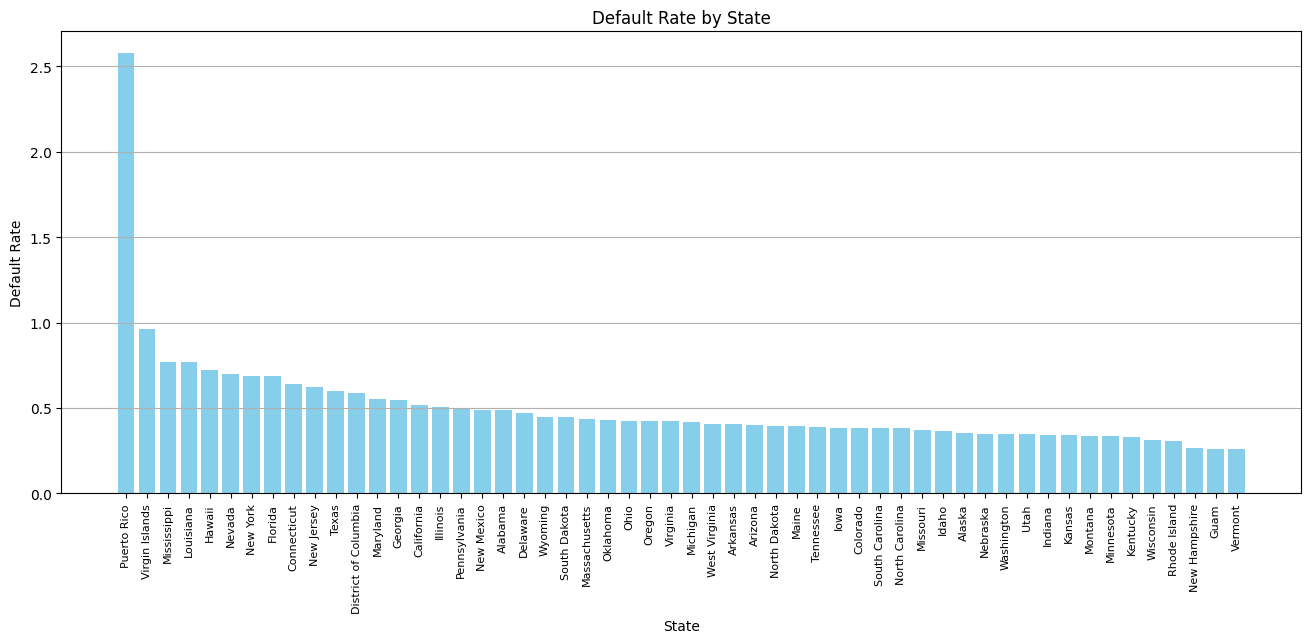

In [43]:
state_group = main()


In [44]:
# Check average default rates per cluster
cluster_avg = state_group.groupby('cluster')['default_rate'].mean().sort_values()
print("Cluster Averages (lowest to highest):")
print(cluster_avg)

# Map labels based on sorted order (lowest = Low Risk, etc.)
risk_labels = ['Low Risk', 'Moderate Risk', 'High Risk']
ordered_labels = {cluster: label for cluster, label in zip(cluster_avg.index, risk_labels)}
print("\nCluster → Risk Label Mapping:")
print(ordered_labels)

# Apply final mapping
state_group['risk_category'] = state_group['cluster'].map(ordered_labels)


Cluster Averages (lowest to highest):
cluster
0    0.388874
2    0.680566
1    2.575827
Name: default_rate, dtype: float64

Cluster → Risk Label Mapping:
{0: 'Low Risk', 2: 'Moderate Risk', 1: 'High Risk'}


In [45]:
# Step 1: Check average default rates per cluster
cluster_avg = state_group.groupby('cluster')['default_rate'].mean().sort_values()

# Step 2: Explicitly map clusters based on sorted default rates
# The cluster with lowest avg becomes Low Risk, and so on
ordered_labels = {
    cluster_avg.index[0]: 'Low Risk',
    cluster_avg.index[1]: 'Moderate Risk',
    cluster_avg.index[2]: 'High Risk'
}

# Step 3: Apply the mapping
state_group['risk_category'] = state_group['cluster'].map(ordered_labels)


In [46]:
# Diagnostic check: View how clusters and risk labels are assigned
diagnostic_df = state_group[['PROPERTY STATE', 'default_rate', 'cluster']].copy()

# Explicitly assign ordered risk labels using sorted averages
cluster_avg = diagnostic_df.groupby('cluster')['default_rate'].mean().sort_values()

ordered_labels = {
    cluster_avg.index[0]: 'Low Risk',
    cluster_avg.index[1]: 'Moderate Risk',
    cluster_avg.index[2]: 'High Risk'
}

diagnostic_df['risk_category'] = diagnostic_df['cluster'].map(ordered_labels)

# Sort by default_rate and display
diagnostic_df_sorted = diagnostic_df.sort_values(by='default_rate', ascending=False)
print(diagnostic_df_sorted.to_string(index=False))


PROPERTY STATE  default_rate  cluster risk_category
            PR      2.575827        1     High Risk
            VI      0.964067        2 Moderate Risk
            MS      0.768973        2 Moderate Risk
            LA      0.767897        2 Moderate Risk
            HI      0.723525        2 Moderate Risk
            NV      0.697861        2 Moderate Risk
            NY      0.689111        2 Moderate Risk
            FL      0.686769        2 Moderate Risk
            CT      0.641502        2 Moderate Risk
            NJ      0.624563        2 Moderate Risk
            TX      0.600036        2 Moderate Risk
            DC      0.584629        2 Moderate Risk
            MD      0.552701        2 Moderate Risk
            GA      0.545726        2 Moderate Risk
            CA      0.519312        0      Low Risk
            IL      0.505230        0      Low Risk
            PA      0.490913        0      Low Risk
            NM      0.490091        0      Low Risk
            

In [47]:
# Apply the same correct risk_category to state_group
state_group['risk_category'] = state_group['cluster'].map(ordered_labels)


In [48]:
# Add ISO-3 codes for PR, GU, VI, etc.
state_to_iso3 = {
    'PR': 'PRI', 'VI': 'VIR', 'GU': 'GUM', 'MP': 'MNP', 'AS': 'ASM',
    'DC': 'USA'  # DC uses USA in ISO-3 mode for Plotly
}
state_group['iso3'] = state_group['PROPERTY STATE'].apply(lambda x: state_to_iso3.get(x, x))


In [49]:
print(state_group[['PROPERTY STATE', 'risk_category']].value_counts())


PROPERTY STATE  risk_category
AK              Low Risk         1
PR              High Risk        1
ND              Low Risk         1
NE              Low Risk         1
NH              Low Risk         1
NJ              Moderate Risk    1
NM              Low Risk         1
NV              Moderate Risk    1
NY              Moderate Risk    1
OH              Low Risk         1
OK              Low Risk         1
OR              Low Risk         1
PA              Low Risk         1
RI              Low Risk         1
AL              Low Risk         1
SC              Low Risk         1
SD              Low Risk         1
TN              Low Risk         1
TX              Moderate Risk    1
UT              Low Risk         1
VA              Low Risk         1
VI              Moderate Risk    1
VT              Low Risk         1
WA              Low Risk         1
WI              Low Risk         1
WV              Low Risk         1
NC              Low Risk         1
MT              Low Risk 

In [50]:
print(state_group['risk_category'].value_counts())


risk_category
Low Risk         40
Moderate Risk    13
High Risk         1
Name: count, dtype: int64


In [55]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Step 1: Ensure categorical column is properly formatted
state_group['risk_category_str'] = state_group['risk_category'].astype(str)

# Step 2: Base choropleth (using only the 50 states + DC)
fig = px.choropleth(
    state_group[state_group['PROPERTY STATE'].isin([
        'AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS',
        'KY','LA','ME','MD','MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY',
        'NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV',
        'WI','WY','DC'
    ])],
    locations='PROPERTY STATE',
    locationmode='USA-states',
    color='risk_category_str',
    color_discrete_map={
        'Low Risk': 'green',
        'Moderate Risk': 'orange',
        'High Risk': 'red'
    },
    category_orders={'risk_category_str': ['Low Risk', 'Moderate Risk', 'High Risk']},
    scope='usa',
    template='plotly_white',
    title='Geographic Risk Map of U.S. States and Territories (2014–2024)'
).update_traces(showlegend=False)  # hide duplicate legend

# Step 2.5: Add PR if present
territory_map = {'PR': 'PRI'}
pr_df = state_group[state_group['PROPERTY STATE'].isin(territory_map.keys())].copy()

if not pr_df.empty:
    pr_df['iso3'] = pr_df['PROPERTY STATE'].map(territory_map)
    pr_color = pr_df['risk_category_str'].values[0]
    pr_color_map = {
        'Low Risk': 'green',
        'Moderate Risk': 'orange',
        'High Risk': 'red'
    }

    # Add PR as a separate trace
    fig.add_trace(go.Choropleth(
        locations=pr_df['iso3'],
        z=[1],  # dummy value
        locationmode='ISO-3',
        showscale=False,
        colorscale=[[0, pr_color_map[pr_color]], [1, pr_color_map[pr_color]]],
        hovertext=f"Puerto Rico ({pr_color})",
        hoverinfo='text',
        name='Puerto Rico'
    ))

    # Label PR
    fig.add_trace(go.Scattergeo(
        locationmode='ISO-3',
        locations=pr_df['iso3'],
        text='PR',
        mode='text',
        textfont=dict(color='black', size=8),
        showlegend=False
    ))


# Step 3: Add dummy invisible traces to force full legend (Low, Moderate, High Risk)
fig.add_trace(go.Scattergeo(
    locationmode='USA-states',
    locations=["CA"],
    mode='markers',
    marker=dict(color='green', size=0.01),
    name='Low Risk',
    showlegend=True
))

fig.add_trace(go.Scattergeo(
    locationmode='USA-states',
    locations=["TX"],
    mode='markers',
    marker=dict(color='orange', size=0.01),
    name='Moderate Risk',
    showlegend=True
))

fig.add_trace(go.Scattergeo(
    locationmode='USA-states',
    locations=["NY"],
    mode='markers',
    marker=dict(color='red', size=0.01),
    name='High Risk',
    showlegend=True
))

# Step 4: Add state abbreviations (skip small territories)
for i, row in state_group.iterrows():
    if row['PROPERTY STATE'] not in ['PR', 'VI', 'GU', 'MP', 'AS']:
        fig.add_trace(go.Scattergeo(
            locationmode='USA-states',
            locations=[row['PROPERTY STATE']],
            text=row['PROPERTY STATE'],
            mode='text',
            textfont=dict(color='black', size=8),
            showlegend=False
        ))

# Step 5: Layout update
fig.update_layout(
    geo=dict(
        scope='usa',
        showland=True,
        landcolor='white',
        bgcolor='white'
    ),
    margin=dict(l=0, r=0, t=50, b=0),
    legend_title_text="Risk Category"
)

fig.show()
